In [18]:
from utils.baseline import *
from skimage.measure import shannon_entropy
from scipy.ndimage import center_of_mass
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from PIL import Image
from torchvision import models, transforms
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import umap

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(42)
np.random.seed(42)
cv2.setRNGSeed(42)
os.environ["PYTHONHASHSEED"] = "42"

In [3]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df = data_df.head(100)

In [15]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

def plot_clusters(data_df, locations_encoded, all_labels):
    import matplotlib.pyplot as plt

    for view in range(5):
        features = np.array(locations_encoded[view])
        labels = np.array(all_labels[view])

        # Get corresponding locations for this view
        loc1_names = data_df["location_name_1"].tolist()
        loc2_names = data_df["location_name_2"].tolist()

        # Map names to their descriptors for current view
        loc1_desc = []
        loc1_labels = []
        loc2_desc = []
        loc2_labels = []

        for i in range(len(data_df)):
            loc1_desc.append(locations_encoded[view][i])
            loc2_desc.append(locations_encoded[view][i])
            loc1_labels.append(all_labels[view][i])
            loc2_labels.append(all_labels[view][i])

        loc1_desc = np.array(loc1_desc)
        loc2_desc = np.array(loc2_desc)
        loc1_labels = np.array(loc1_labels)
        loc2_labels = np.array(loc2_labels)

        reducer_umap = umap.UMAP(n_components=2, random_state=42)
        reducer_tsne = TSNE(n_components=2, random_state=42)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f"View {view} - 2D Projections of Descriptors", fontsize=16)

        # Location 1: UMAP
        loc1_umap = reducer_umap.fit_transform(loc1_desc)
        axes[0, 0].scatter(loc1_umap[:, 0], loc1_umap[:, 1], c=loc1_labels, cmap='tab10', s=10)
        axes[0, 0].set_title("Location 1 - UMAP")

        # Location 1: t-SNE
        loc1_tsne = reducer_tsne.fit_transform(loc1_desc)
        axes[0, 1].scatter(loc1_tsne[:, 0], loc1_tsne[:, 1], c=loc1_labels, cmap='tab10', s=10)
        axes[0, 1].set_title("Location 1 - t-SNE")

        # Location 2: UMAP
        loc2_umap = reducer_umap.fit_transform(loc2_desc)
        axes[1, 0].scatter(loc2_umap[:, 0], loc2_umap[:, 1], c=loc2_labels, cmap='tab10', s=10)
        axes[1, 0].set_title("Location 2 - UMAP")

        # Location 2: t-SNE
        loc2_tsne = reducer_tsne.fit_transform(loc2_desc)
        axes[1, 1].scatter(loc2_tsne[:, 0], loc2_tsne[:, 1], c=loc2_labels, cmap='tab10', s=10)
        axes[1, 1].set_title("Location 2 - t-SNE")

        for ax in axes.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Histogram plot (Second figure)
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        fig2.suptitle(f"View {view} - Cluster Label Distributions", fontsize=16)

        sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
        ax1.set_title("Location 1 Cluster Histogram")
        ax1.set_xlabel("Cluster Label")
        ax1.set_ylabel("Count")

        sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')
        ax2.set_title("Location 2 Cluster Histogram")
        ax2.set_xlabel("Cluster Label")
        ax2.set_ylabel("Count")

        plt.tight_layout()
        plt.show()


def get_deep_description(location, view):
    img_path_1 = f"./Eynsham/Images/{location}-{view}.ppm"
    img = Image.open(img_path_1)
    input_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        embedding = model(input_tensor).squeeze().numpy()
    return embedding

def get_classical_description(location, view):
    img_path_1 = f"./Eynsham/Images/{location}-{view}.ppm"
    img = cv2.imread(img_path_1, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    entropy = shannon_entropy(img)
    moments = cv2.moments(img)
    hu_moments = cv2.HuMoments(moments).flatten()
    com = center_of_mass(img)
    features = np.concatenate([
        [entropy],
        hu_moments,
        [edge_density],
        com])
    return features.copy()

def cluster(features):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=10, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    return kmeans, scaler, labels

def get_classical_results(data_df, descriptors, method, all_clusters, all_scalers, all_labels):
    results = {}
    for view in range(5):
        clusterer = all_clusters[view]
        scaler = all_scalers[view]
        labels = all_labels[view]
        similarities = {}
        desc_loc1 = {}
        desc_loc2 = {}
        loc1_labels = {}

        for i in range(len(data_df)):
            location_1 = data_df.iloc[i]["location_name_1"]
            img_path_1 = f"./Eynsham/Images/{location_1}-{view}.ppm"
            img_1 = cv2.imread(img_path_1, cv2.IMREAD_GRAYSCALE)
            if img_1 is None or not (img_1.dtype == np.uint8) or not (img_1.min() >= 0) or not (img_1.max() <= 255):
                print(f"Warning: Could not load {img_path_1}")
                continue
        
            if method == "ORB":
                kp1, des1 = get_ORB(img_1, nfeatures=500)
            elif method == "SIFT":
                kp1, des1 = get_SIFT(img_1)
            else:
                raise ValueError("Method must be ORB or SIFT")
            desc_loc1[location_1] = des1

            if descriptors == "classical":
                img_features = get_classical_description(location_1, view)
            elif descriptors == "deep":
                pass
                img_features = get_deep_description(location_1, view)
            else:
                raise ValueError("Invalid Method")
            img_features = scaler.transform([img_features])
            predicted_cluster = clusterer.predict(img_features)[0]
            loc1_labels[location_1] = predicted_cluster

        for i in range(len(data_df)):
            location_2 = data_df.iloc[i]["location_name_2"]
            img_path_2 = f"./Eynsham/Images/{location_2}-{view}.ppm"
            img_2 = cv2.imread(img_path_2, cv2.IMREAD_GRAYSCALE)
            if img_2 is None or not (img_2.dtype == np.uint8) or not (img_2.min() >= 0) or not (img_2.max() <= 255):
                print(f"Warning: Could not load {img_path_2}")
                continue
        
            if method == "ORB":
                kp2, des2 = get_ORB(img_2, nfeatures=500)
            elif method == "SIFT":
                kp2, des2 = get_SIFT(img_2)
            else:
                raise ValueError("Method must be ORB or SIFT")
            desc_loc2[location_2] = des2

        for i in range(len(data_df)):
            location_1 = data_df.iloc[i]["location_name_1"]
            loc1_label = loc1_labels[location_1]
            similarities[location_1] = {}
            des1 = desc_loc1[location_1]

            for j in range(len(data_df)):
                location_2 = data_df.iloc[j]["location_name_2"]
                des2 = desc_loc2[location_2]
                loc2_label = labels[j]

                if loc2_label == loc1_label:
                    if method == "ORB":
                        good = compare_ORB(des1, des2, ratio_thresh=0.75)
                    elif method == "SIFT":
                        good = compare_SIFT(des1, des2, ratio_thresh=0.75)
                    else:
                        raise ValueError("Method must be ORB or SIFT")
                else:
                    good = []

                similarities[location_1][location_2] = good
        results[view] = similarities
    return results


def find_images_fast(data_df, descriptors, method, plot):
    locations_encoded = {}
    for view in range(5):
        locations_encoded[view] = []
    
    for i in range(len(data_df)):
        for view in range(5):
            location = data_df.iloc[i]["location_name_2"]
            if descriptors == "classical":
                desc_img = get_classical_description(location, view)
            elif descriptors == "deep":
                pass
                desc_img = get_deep_description(location, view)
            else:
                raise ValueError("Invalid Method")
            locations_encoded[view].append(desc_img)

    all_clusters = {}
    all_scalers = {}
    all_labels = {}
    for view in range(5):
        clusterer, scaler, labels = cluster(locations_encoded[view])
        all_clusters[view] = clusterer
        all_scalers[view] = scaler
        all_labels[view] = labels
    
    if plot:
        plot_clusters(data_df, locations_encoded, all_labels)


    if method == "ORB" or method=="SIFT":
        results = get_classical_results(data_df, descriptors, method, all_clusters, all_scalers, all_labels)
    elif method == "VLAD":
        pass
        #results = get_VLAD_results()
    else:
        raise ValueError("Invalid Method")
    return results

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
%%time
ORB_baseline_results = get_baseline(data_df, "ORB", nfeatures=500, ratio_thresh=0.75)

Processing View: 0
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:03<00:00, 25.86it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:01<00:00, 65.76it/s]


Calculating distances


100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Processing View: 1
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:02<00:00, 41.44it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:01<00:00, 75.53it/s]


Calculating distances


100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Processing View: 2
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:01<00:00, 62.00it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:01<00:00, 71.78it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 11.07it/s]


Processing View: 3
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:01<00:00, 62.17it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


Processing View: 4
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:02<00:00, 45.89it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:01<00:00, 61.24it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 10.67it/s]

CPU times: user 6min 17s, sys: 1min 38s, total: 7min 56s
Wall time: 1min 4s


In [6]:
ORB_baseline_results = get_baseline(data_df, "ORB", nfeatures=500, ratio_thresh=0.75)
orb_acc_weighted, orb_top5_weighted = evaluate_accuracy_weighted_aggregation(data_df, ORB_baseline_results, top_k=5)
orb_acc_weighted, orb_top10_weighted = evaluate_accuracy_weighted_aggregation(data_df, ORB_baseline_results, top_k=10)
print(f"Weighted Aggregation: Top-1 Accuracy: {orb_acc_weighted:.3f}, Top-5 Accuracy: {orb_top5_weighted:.3f}, Top-10 Accuracy: {orb_top10_weighted:.3f}")

Processing View: 0
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:00<00:00, 214.05it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:00<00:00, 226.09it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


Processing View: 1
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:00<00:00, 203.08it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:00<00:00, 197.55it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 10.06it/s]


Processing View: 2
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:00<00:00, 141.01it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:00<00:00, 183.29it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


Processing View: 3
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:00<00:00, 189.62it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:00<00:00, 200.52it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


Processing View: 4
Precomputing descriptors for locations 1


100%|██████████| 100/100 [00:00<00:00, 138.78it/s]


Precomputing descriptors for locations 2


100%|██████████| 100/100 [00:00<00:00, 191.14it/s]


Calculating distances


100%|██████████| 100/100 [00:09<00:00, 10.50it/s]


Weighted Aggregation: Top-1 Accuracy: 0.830, Top-5 Accuracy: 0.880, Top-10 Accuracy: 0.880


In [7]:
%%time
ORB_fast_results = find_images_fast(data_df, "classical", "ORB", plot=False)

CPU times: user 1min 22s, sys: 34.1 s, total: 1min 56s
Wall time: 22.8 s


In [8]:
ORB_fast_results = find_images_fast(data_df, "classical", "ORB", plot=False)
orb_acc_weighted, orb_top5_weighted = evaluate_accuracy_weighted_aggregation(data_df, ORB_fast_results, top_k=5)
orb_acc_weighted, orb_top10_weighted = evaluate_accuracy_weighted_aggregation(data_df, ORB_fast_results, top_k=10)
print(f"Weighted Aggregation: Top-1 Accuracy: {orb_acc_weighted:.3f}, Top-5 Accuracy: {orb_top5_weighted:.3f}, Top-10 Accuracy: {orb_top10_weighted:.3f}")

Weighted Aggregation: Top-1 Accuracy: 0.680, Top-5 Accuracy: 0.800, Top-10 Accuracy: 0.830


In [13]:
%%time
ORB_fast_results_deep = find_images_fast(data_df, "deep", "ORB", plot=False)

CPU times: user 7min 35s, sys: 33.4 s, total: 8min 8s
Wall time: 1min 18s


In [14]:
ORB_fast_results_deep = find_images_fast(data_df, "deep", "ORB", plot=False)
orb_acc_weighted, orb_top5_weighted = evaluate_accuracy_weighted_aggregation(data_df, ORB_fast_results_deep, top_k=5)
orb_acc_weighted, orb_top10_weighted = evaluate_accuracy_weighted_aggregation(data_df, ORB_fast_results_deep, top_k=10)
print(f"Weighted Aggregation: Top-1 Accuracy: {orb_acc_weighted:.3f}, Top-5 Accuracy: {orb_top5_weighted:.3f}, Top-10 Accuracy: {orb_top10_weighted:.3f}")

Weighted Aggregation: Top-1 Accuracy: 0.810, Top-5 Accuracy: 0.860, Top-10 Accuracy: 0.880


In [19]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df = data_df.head(40)

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


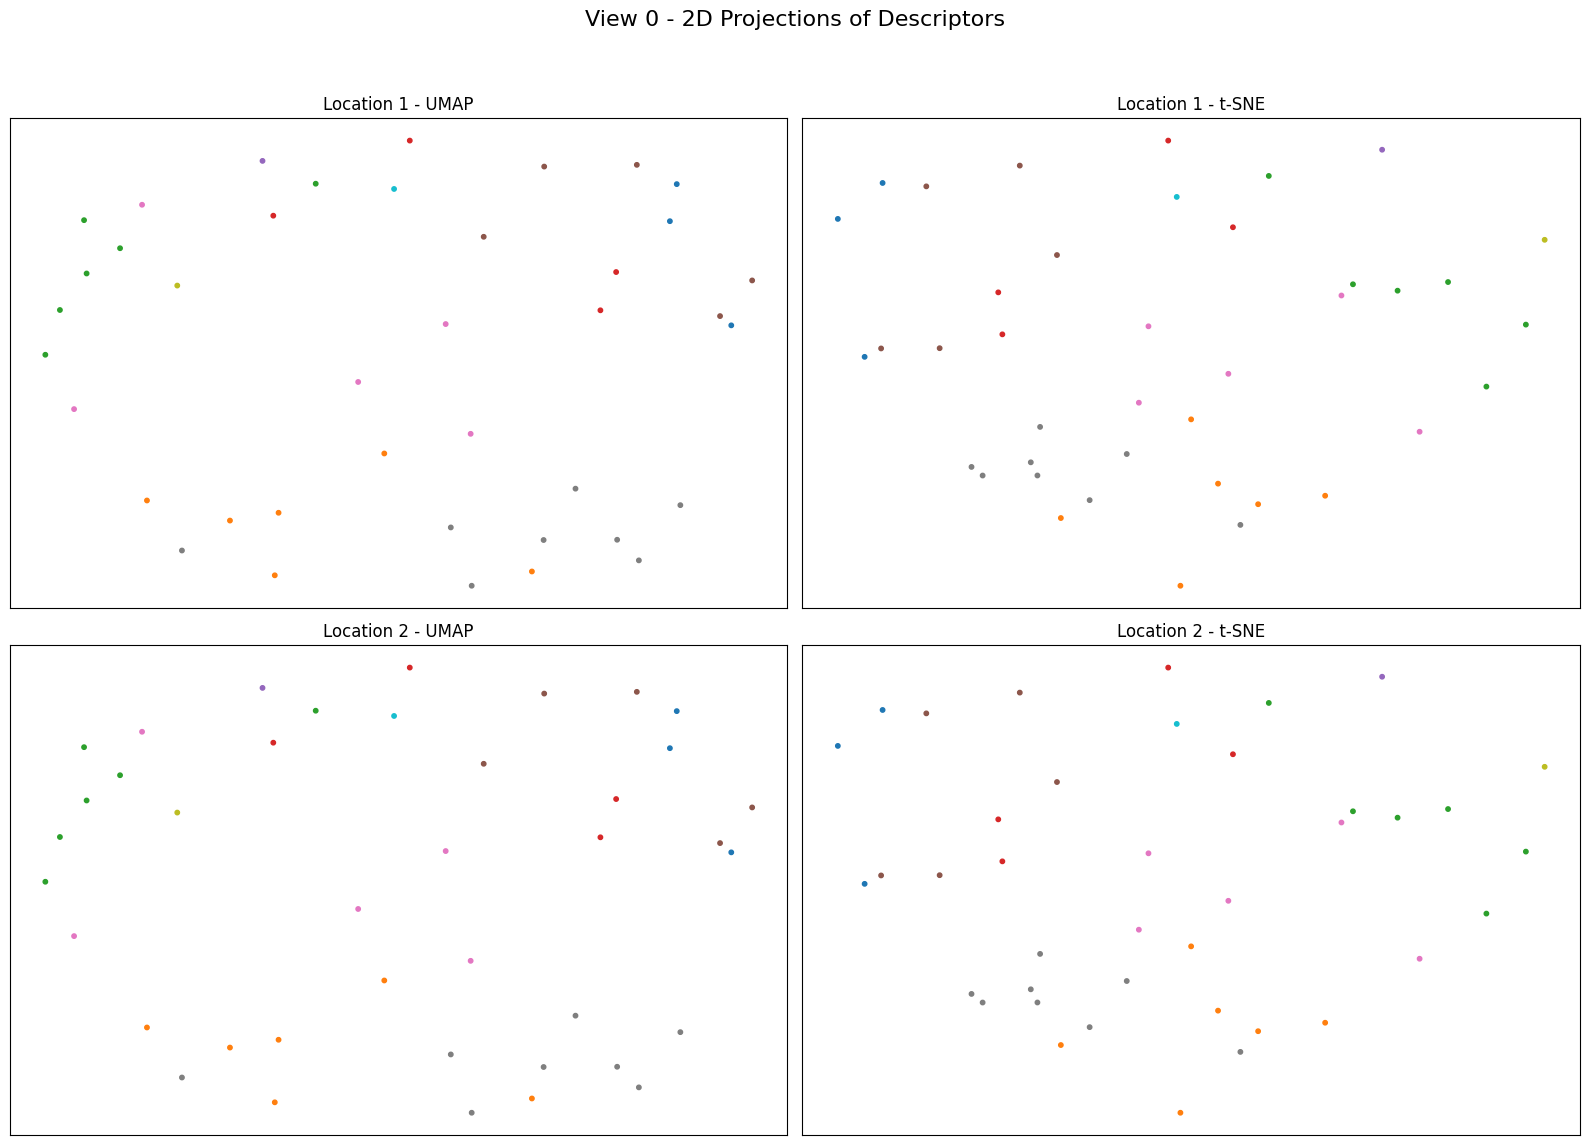

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


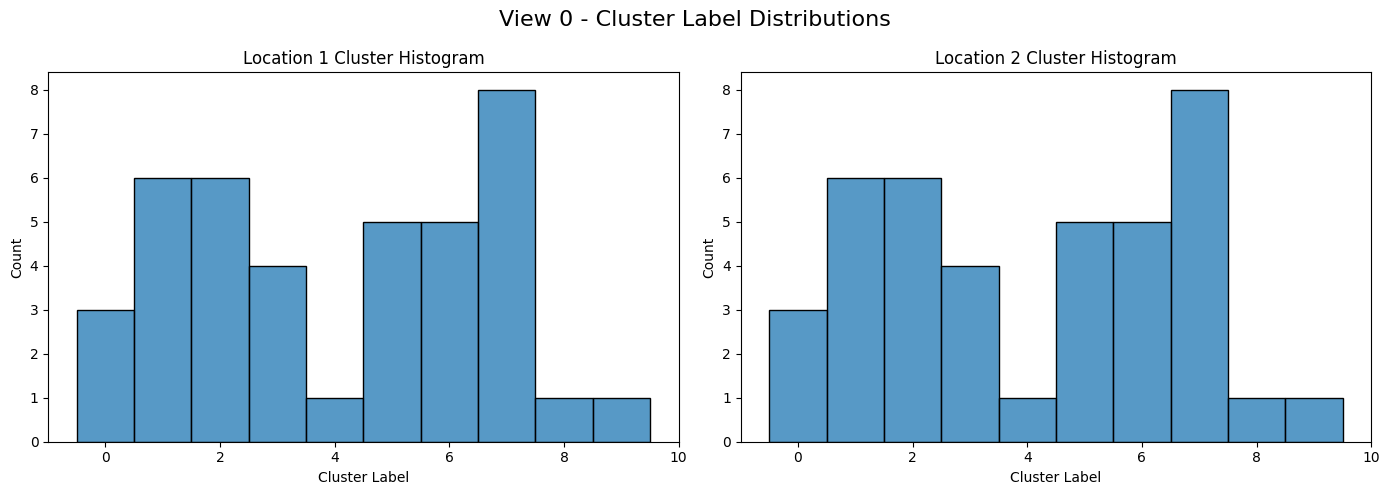

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


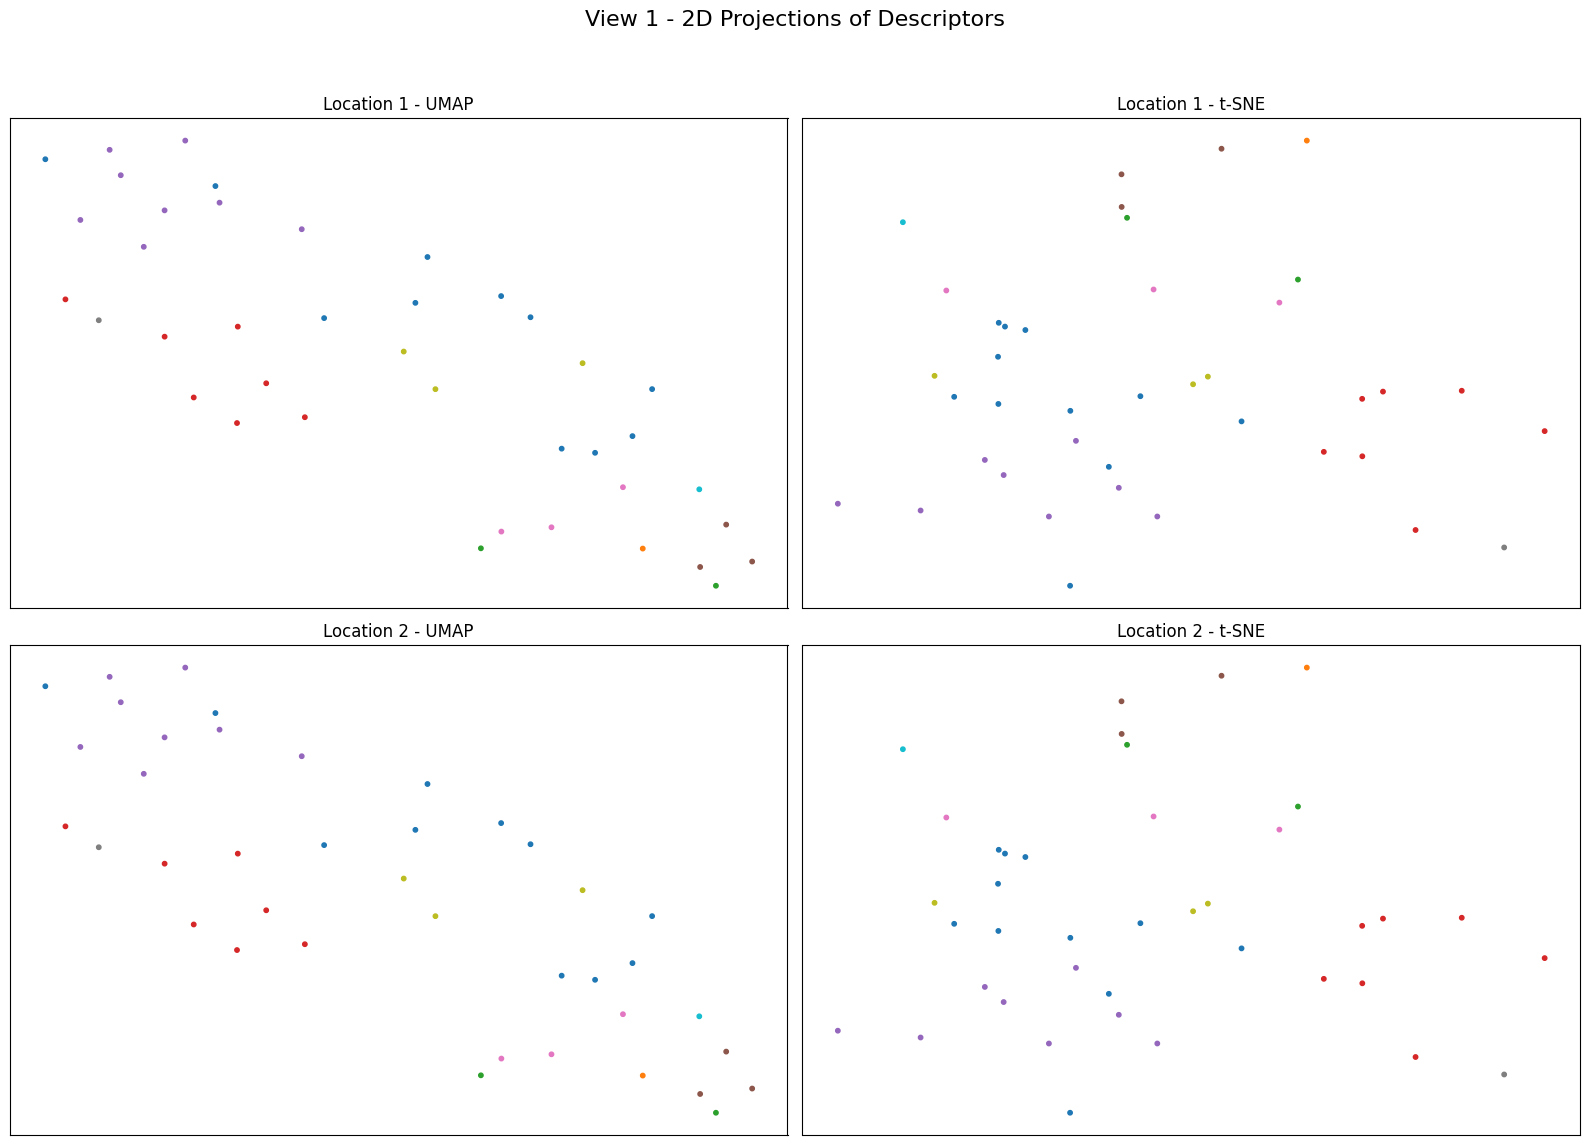

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


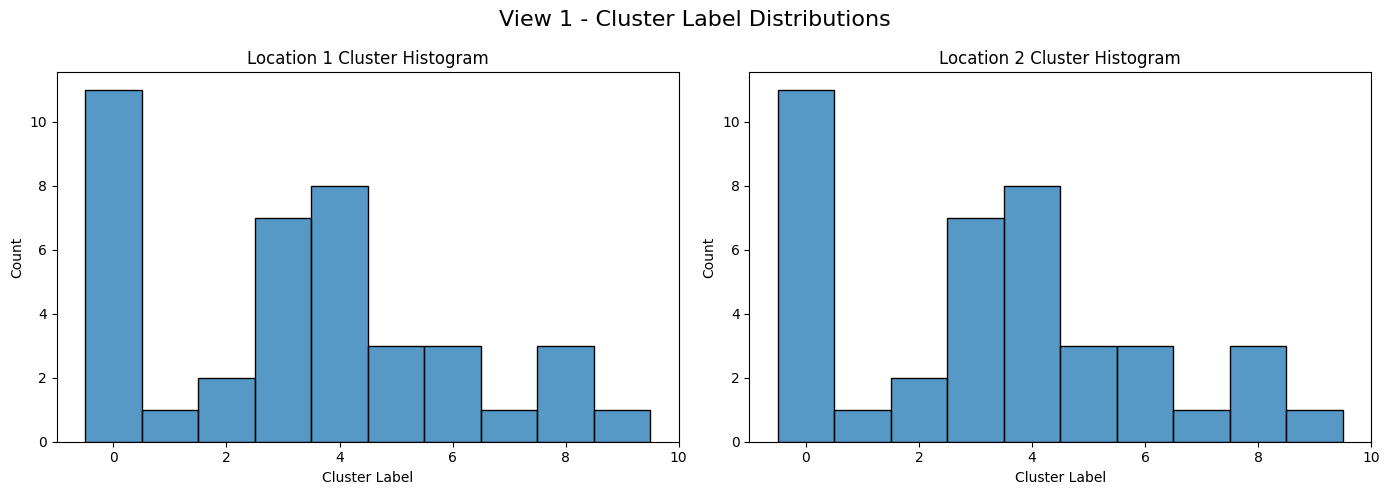

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


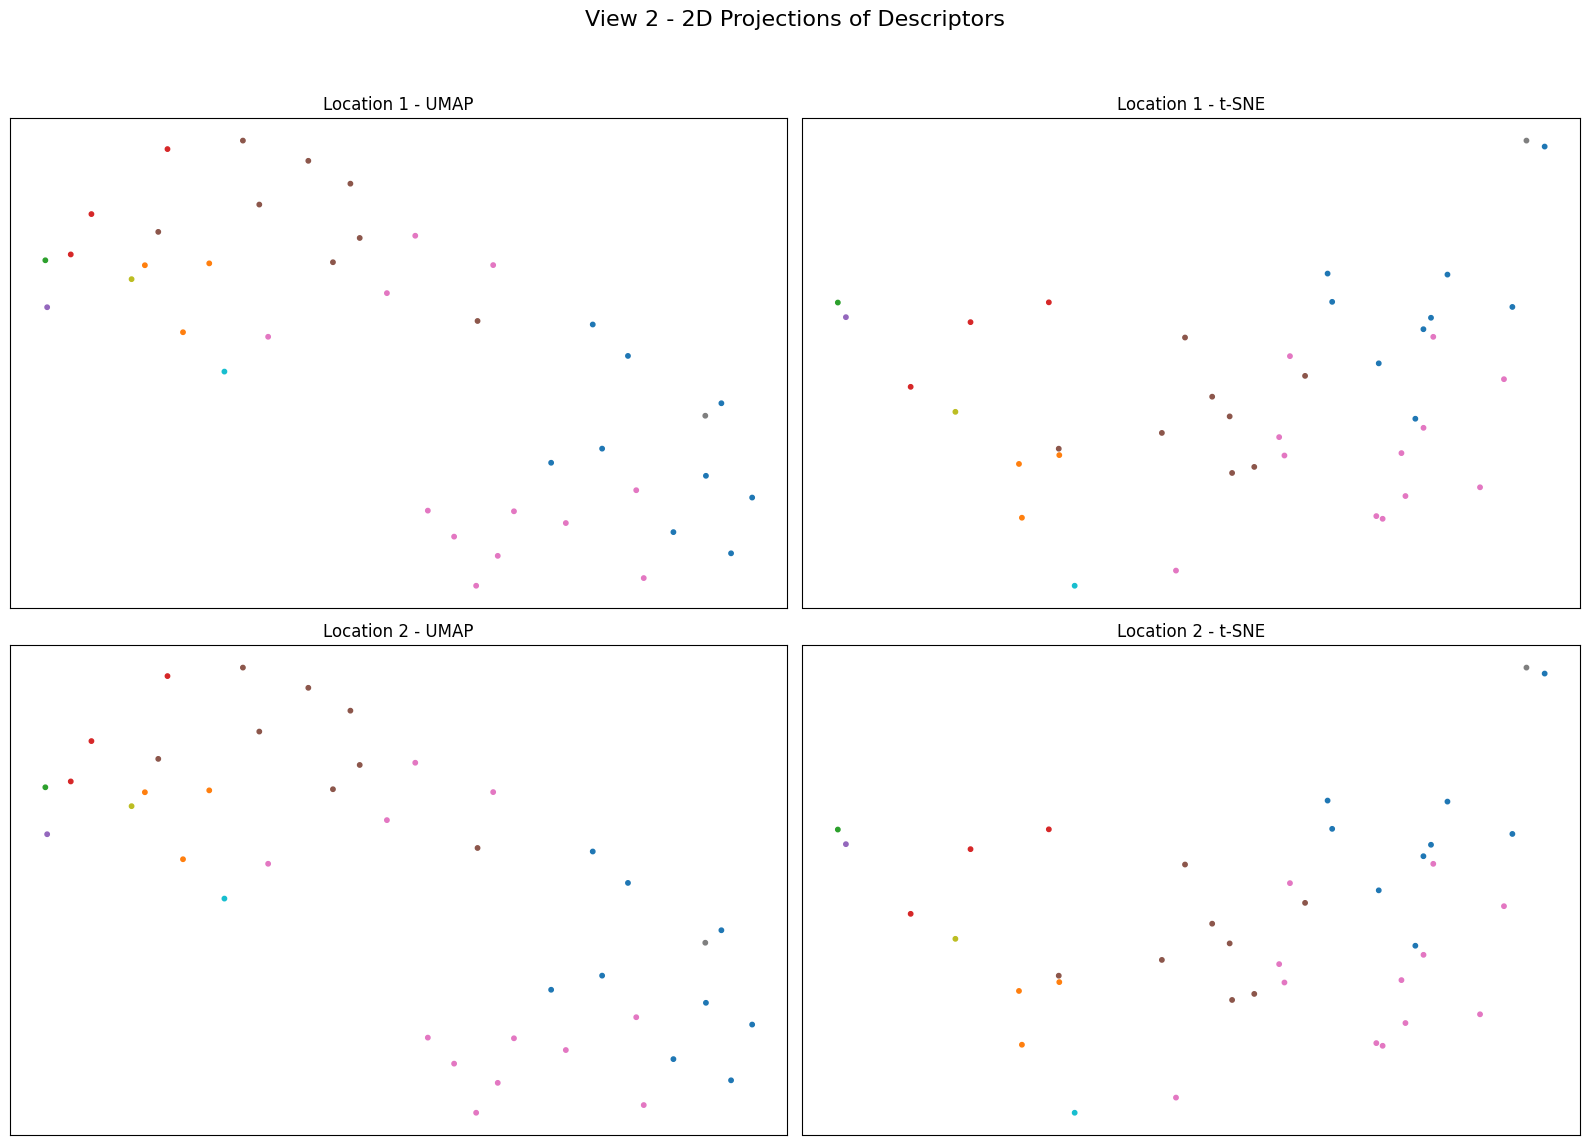

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


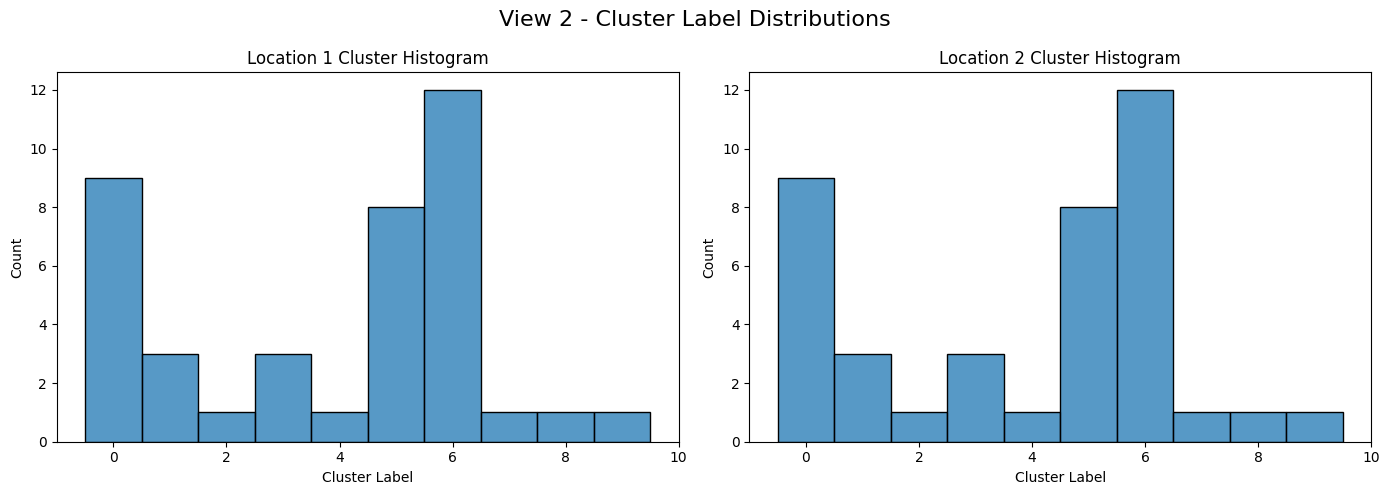

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


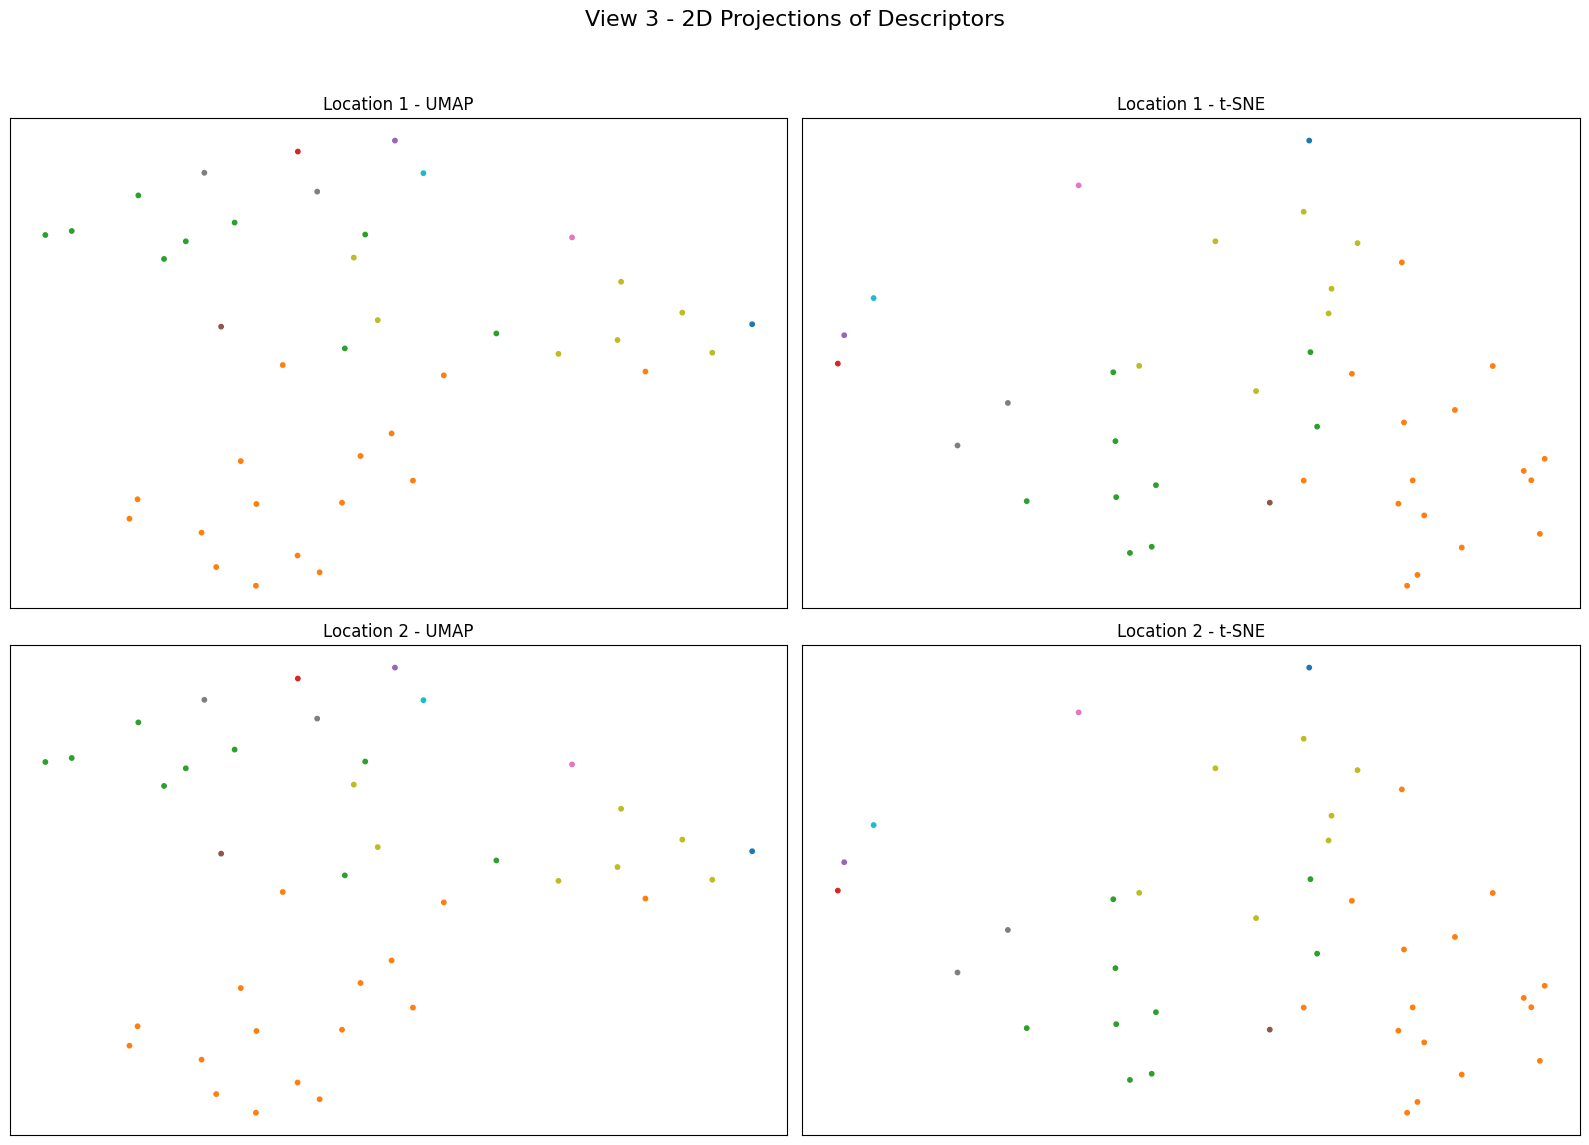

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


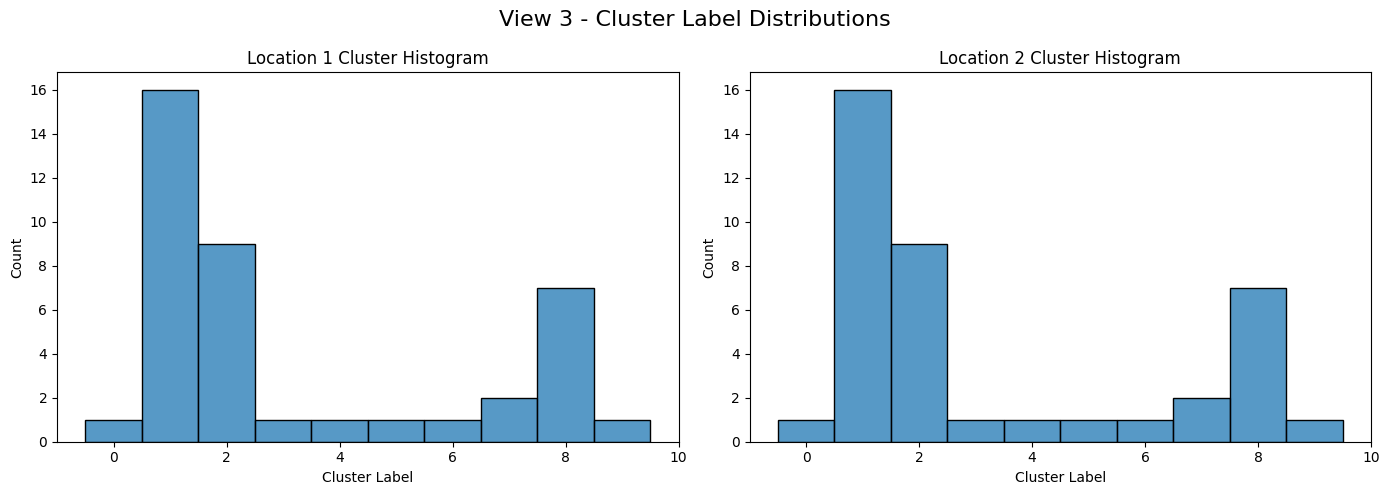

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


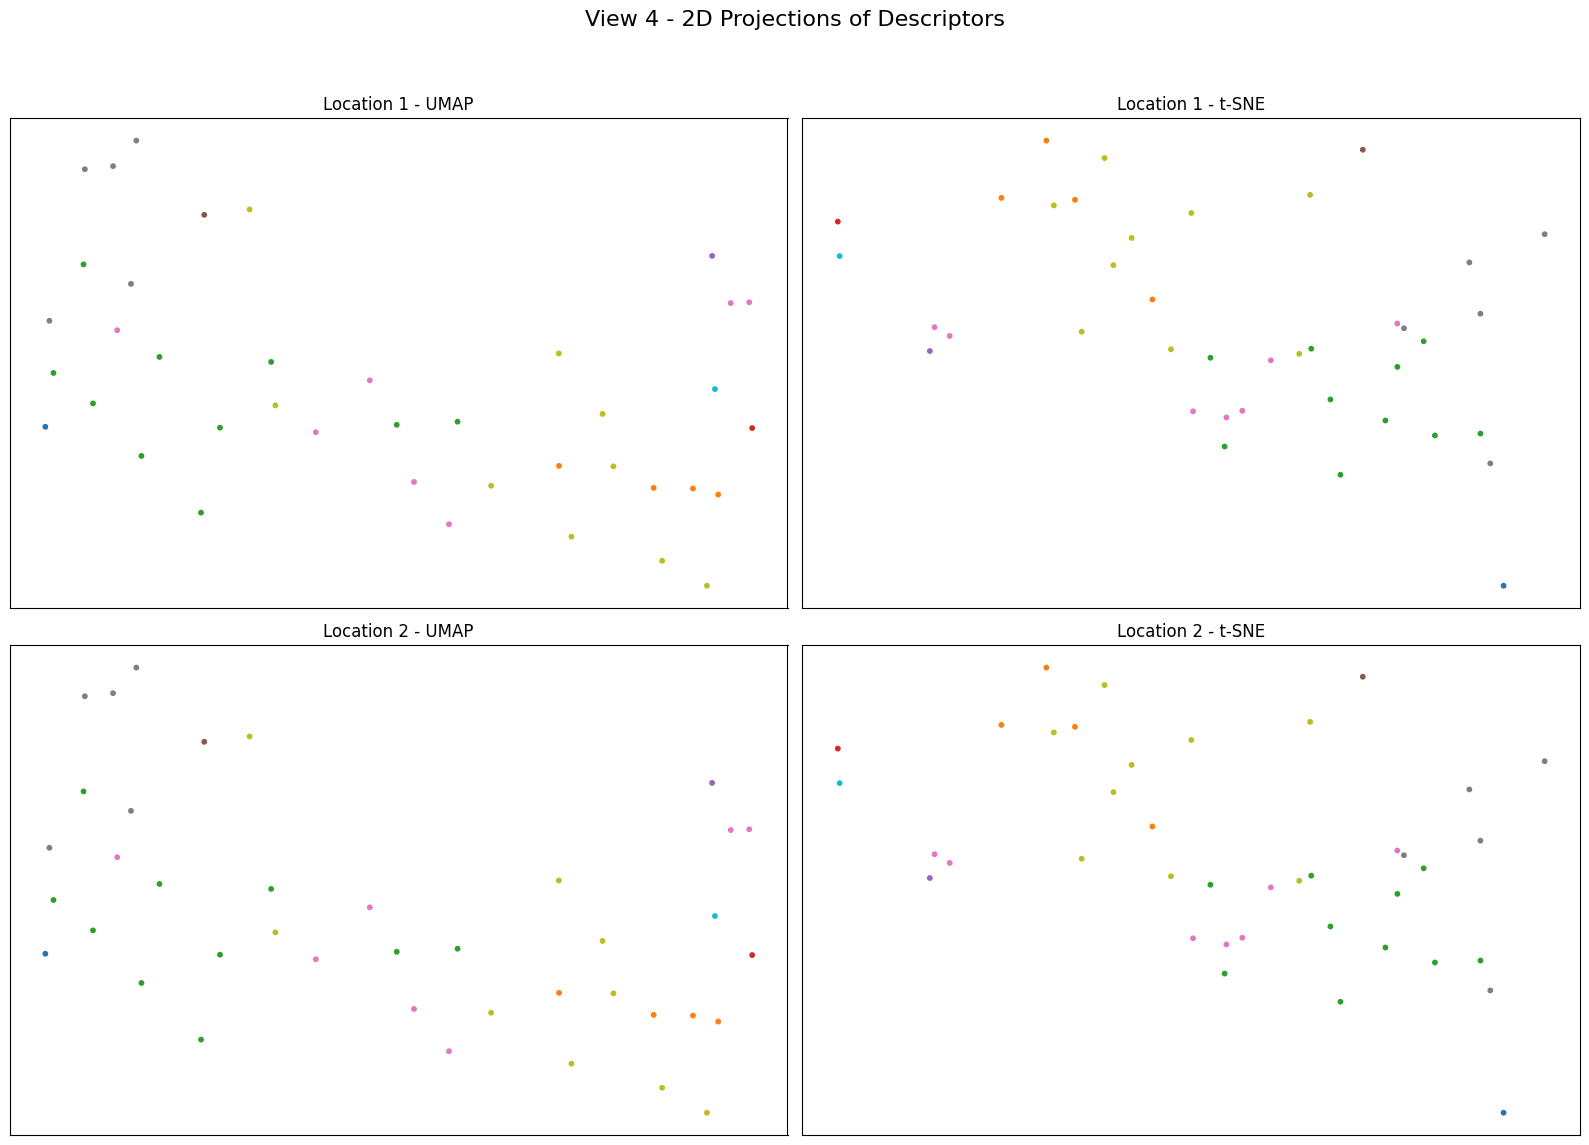

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


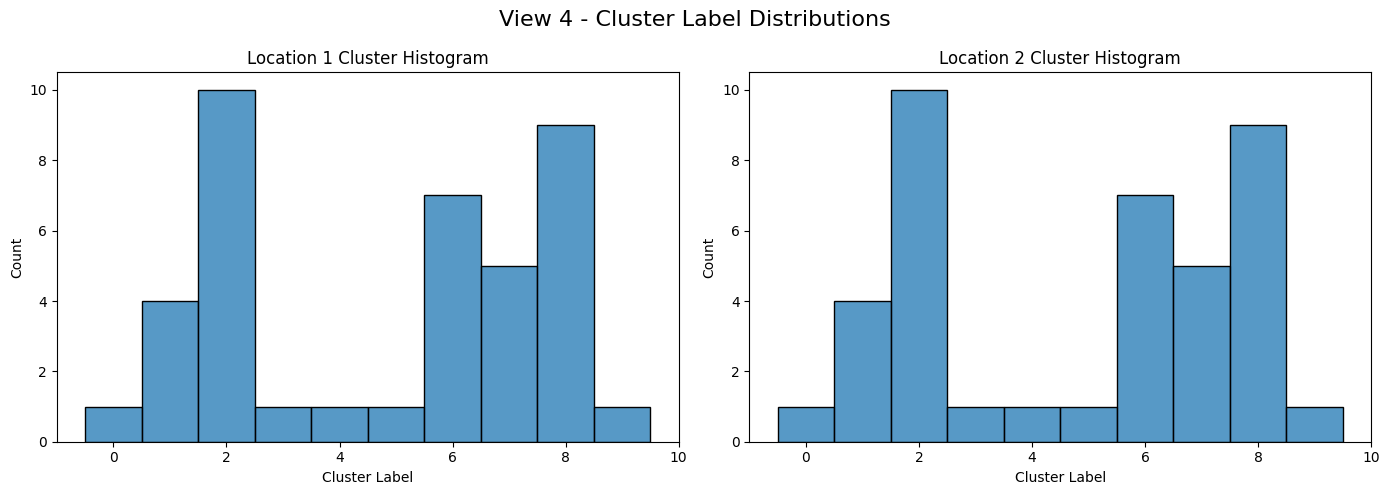

In [20]:
ORB_fast_results = find_images_fast(data_df, "classical", "ORB", plot=True)

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


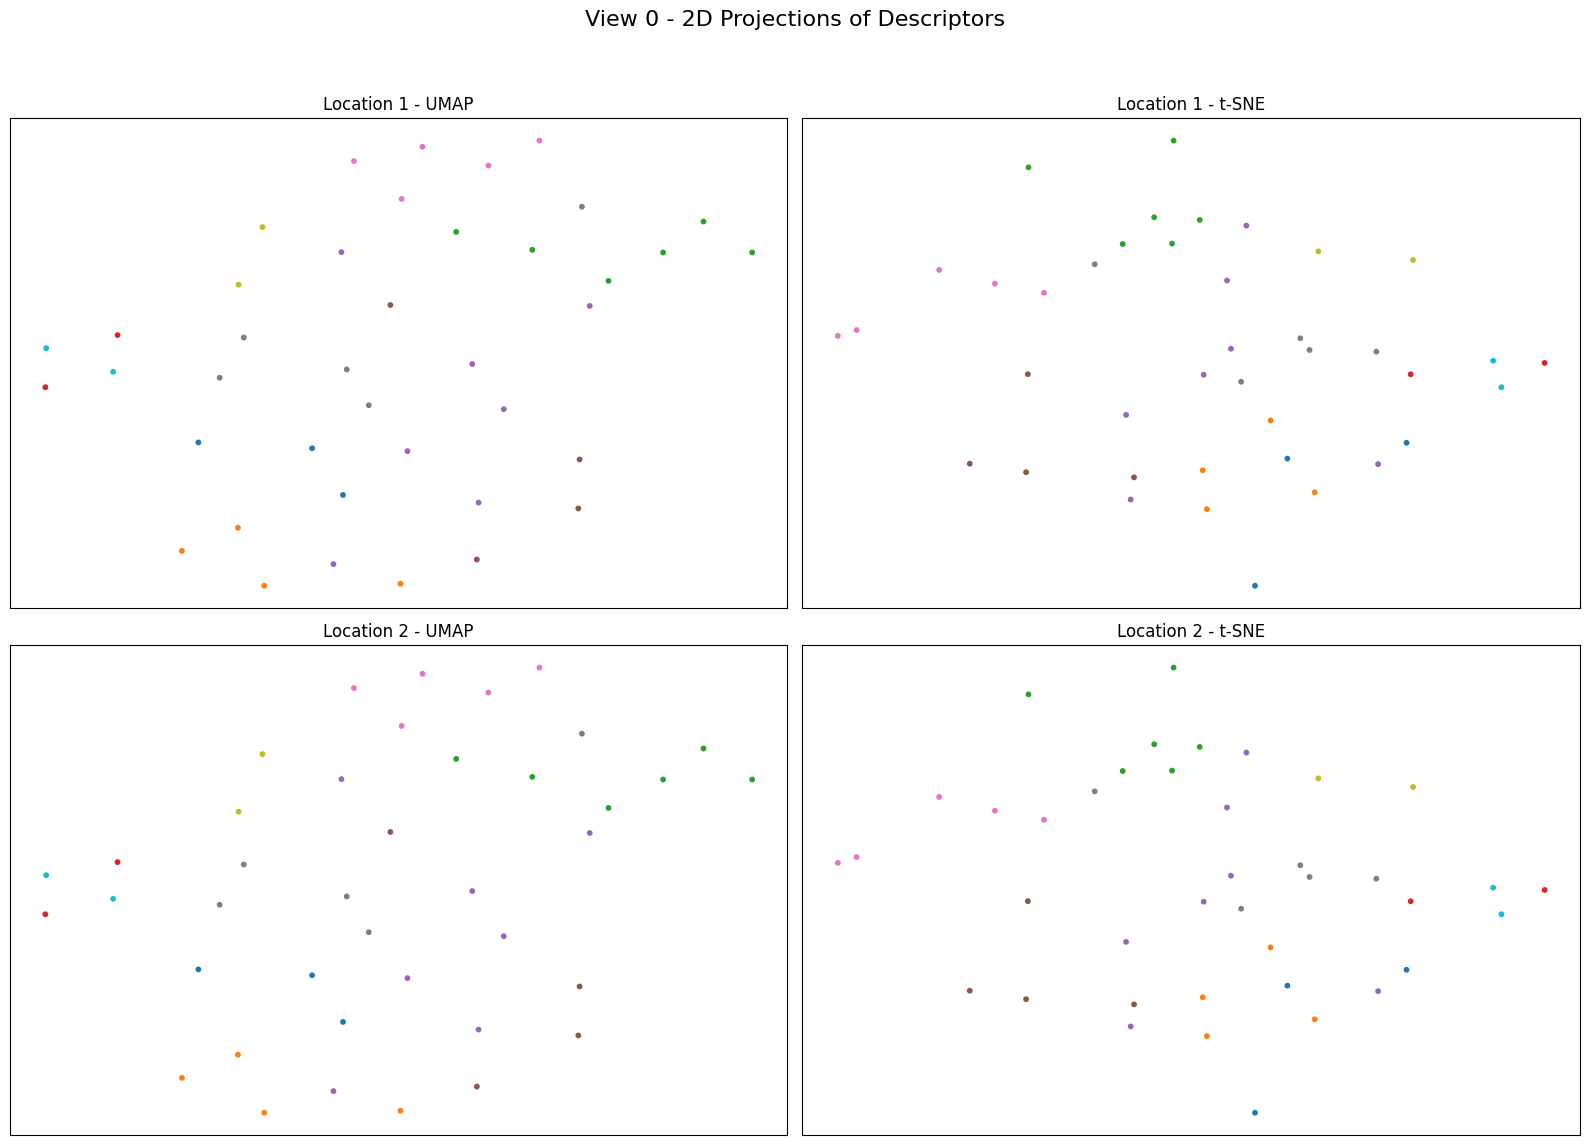

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


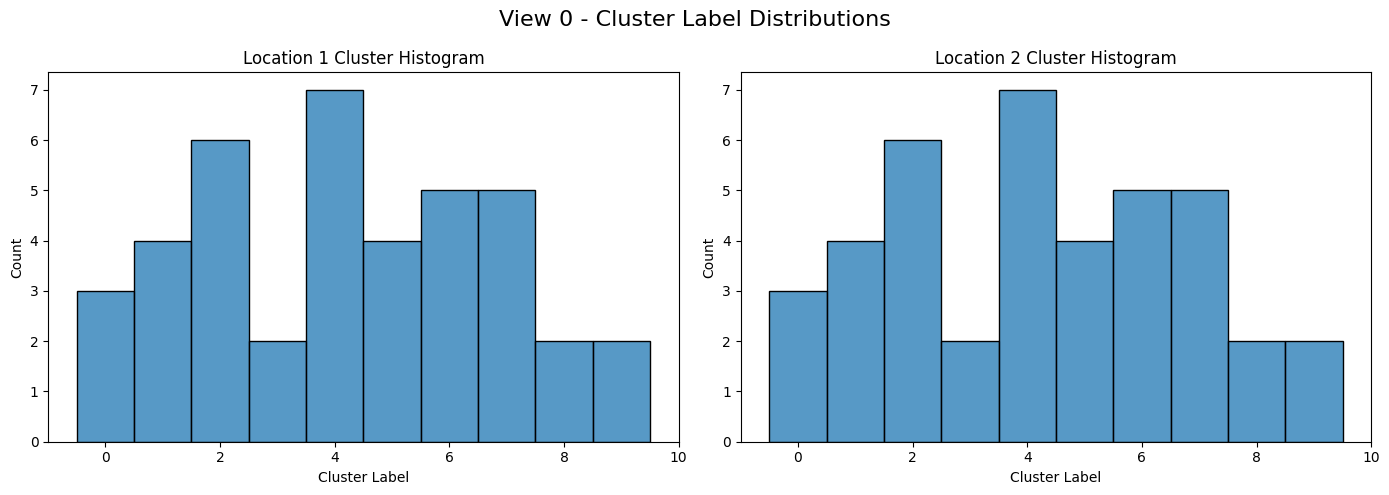

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


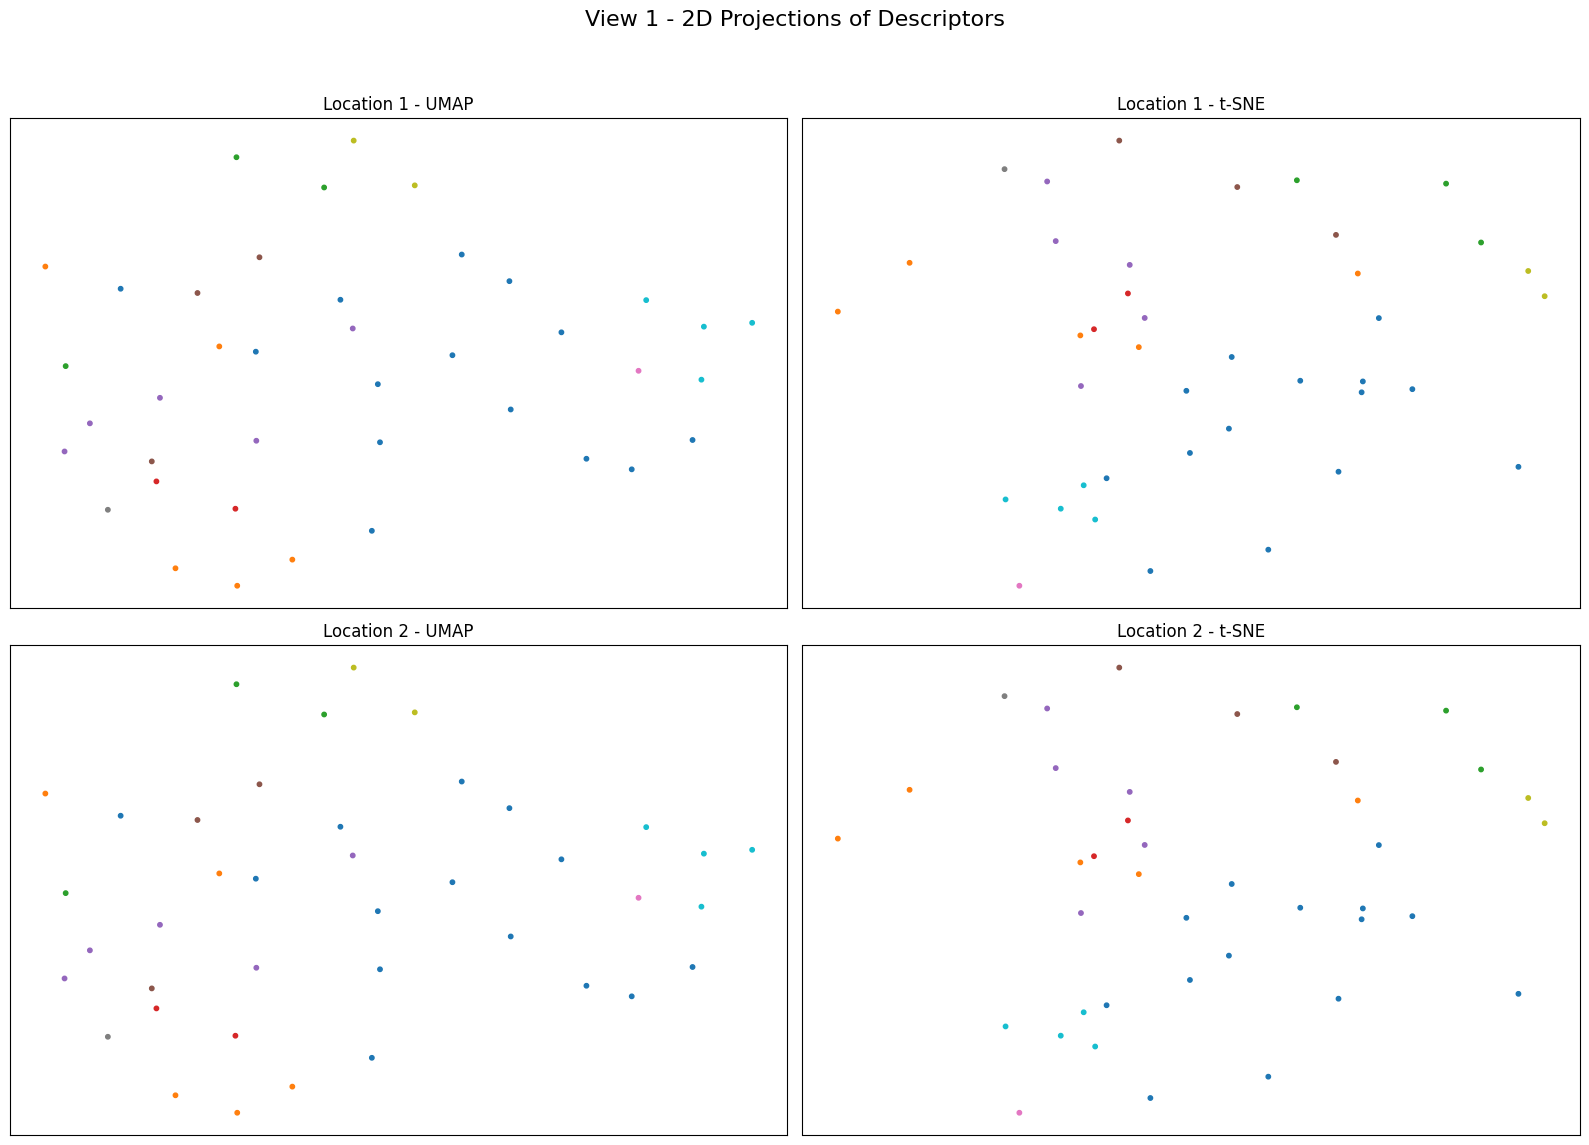

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


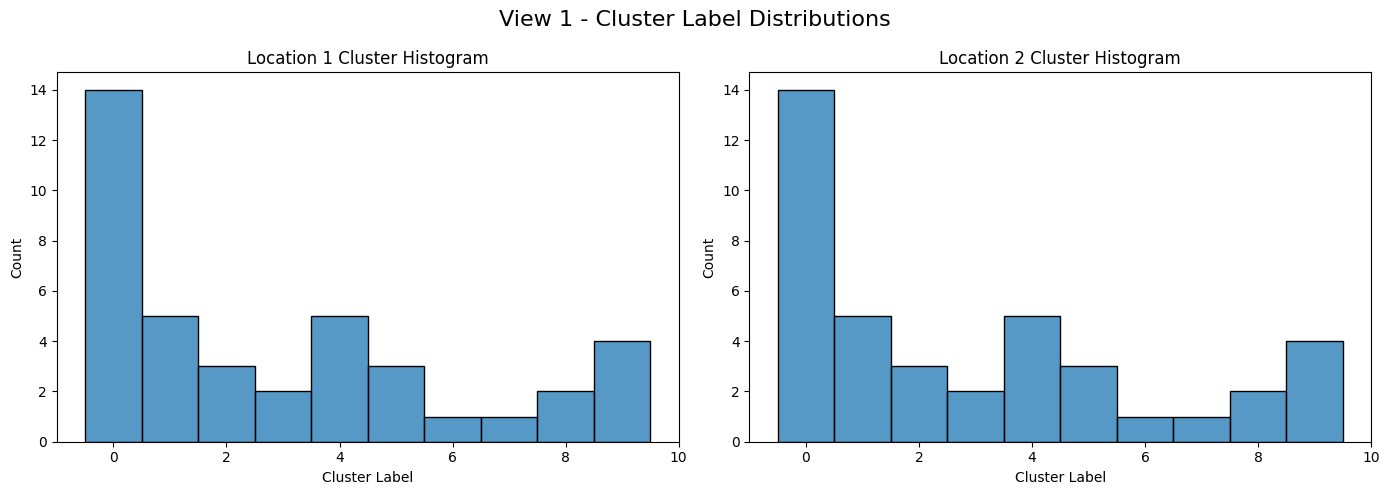

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


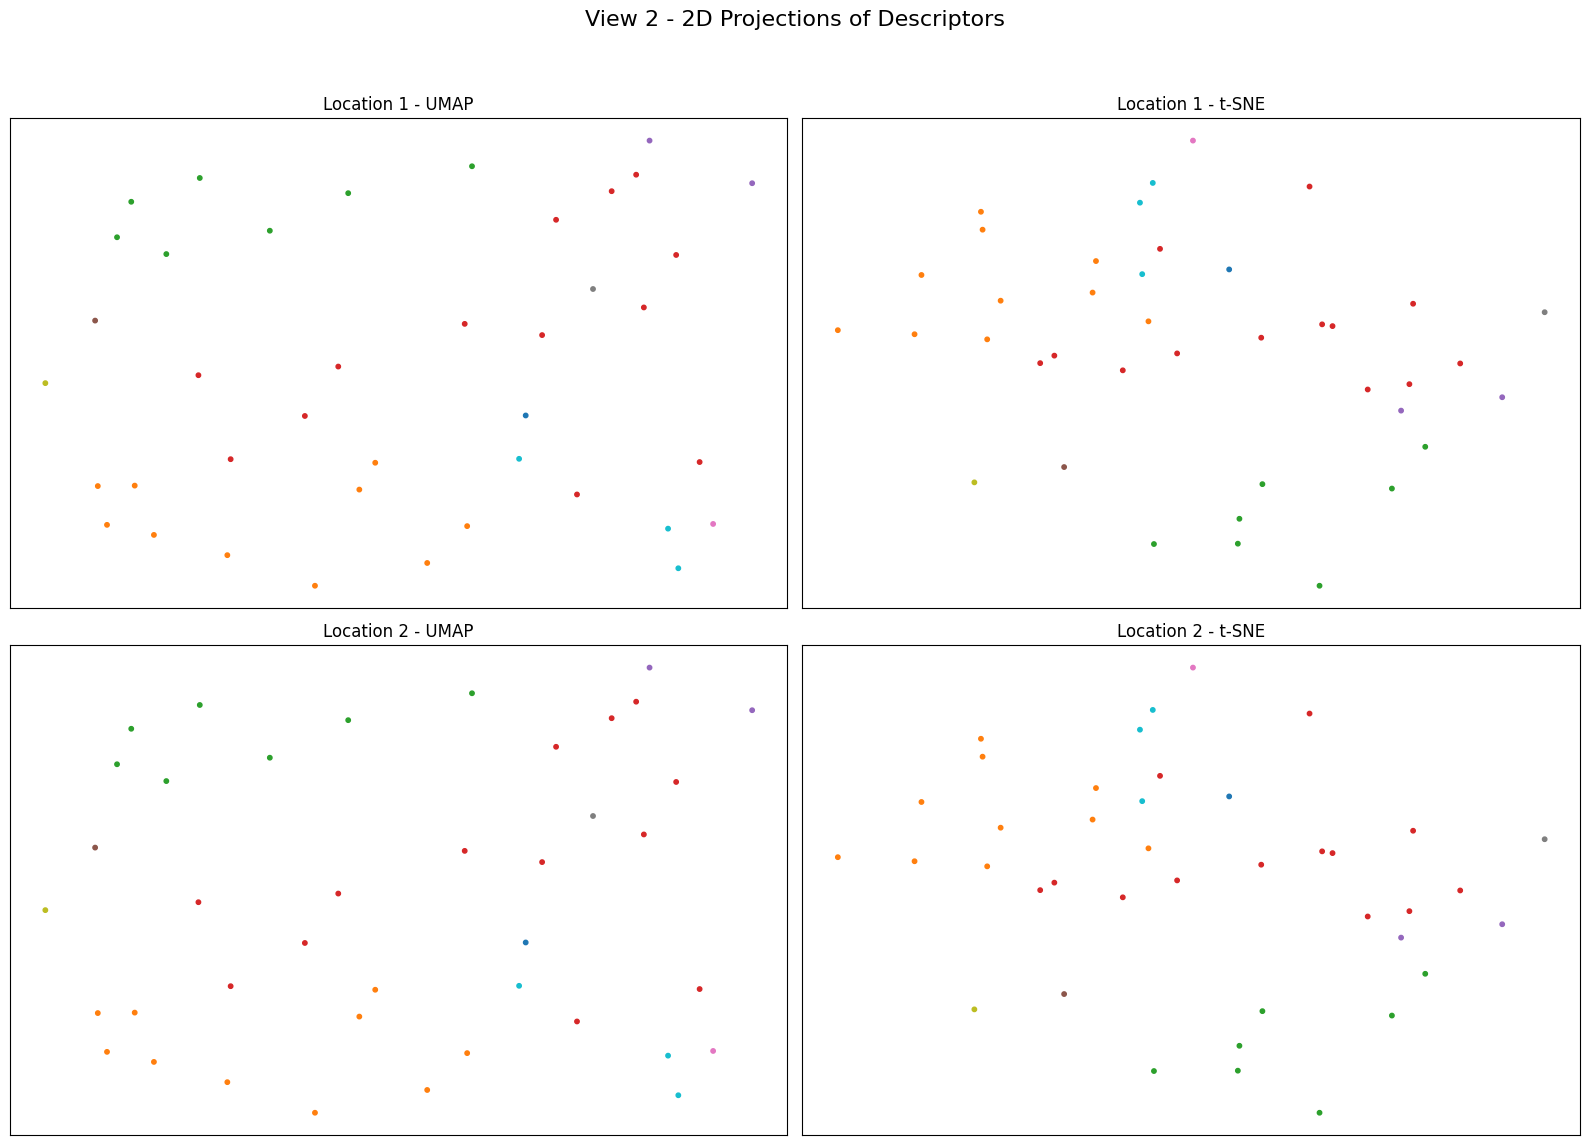

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


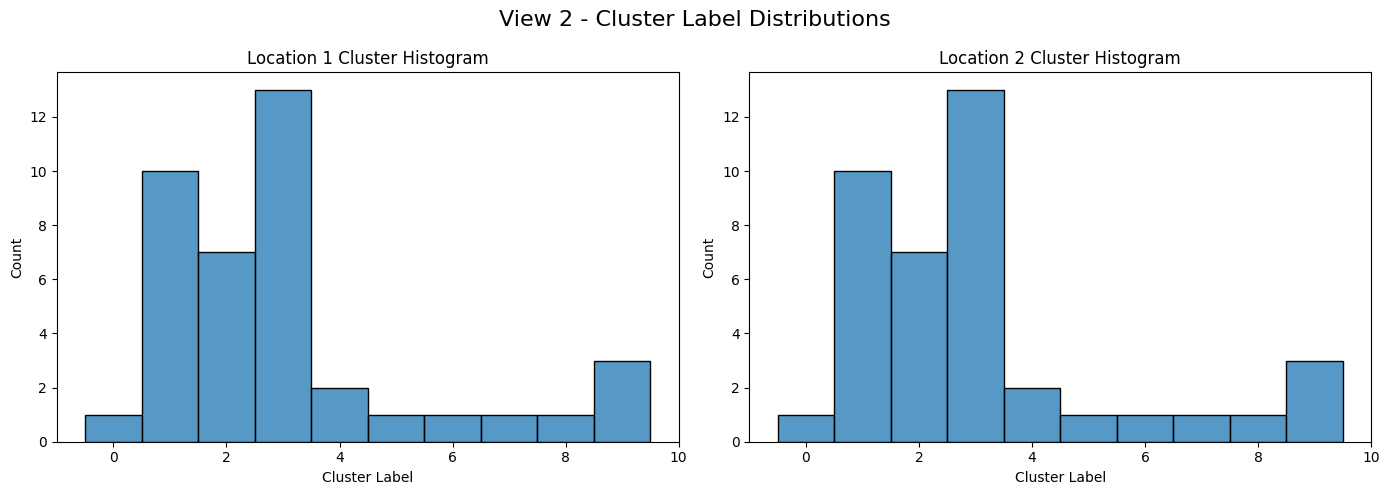

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


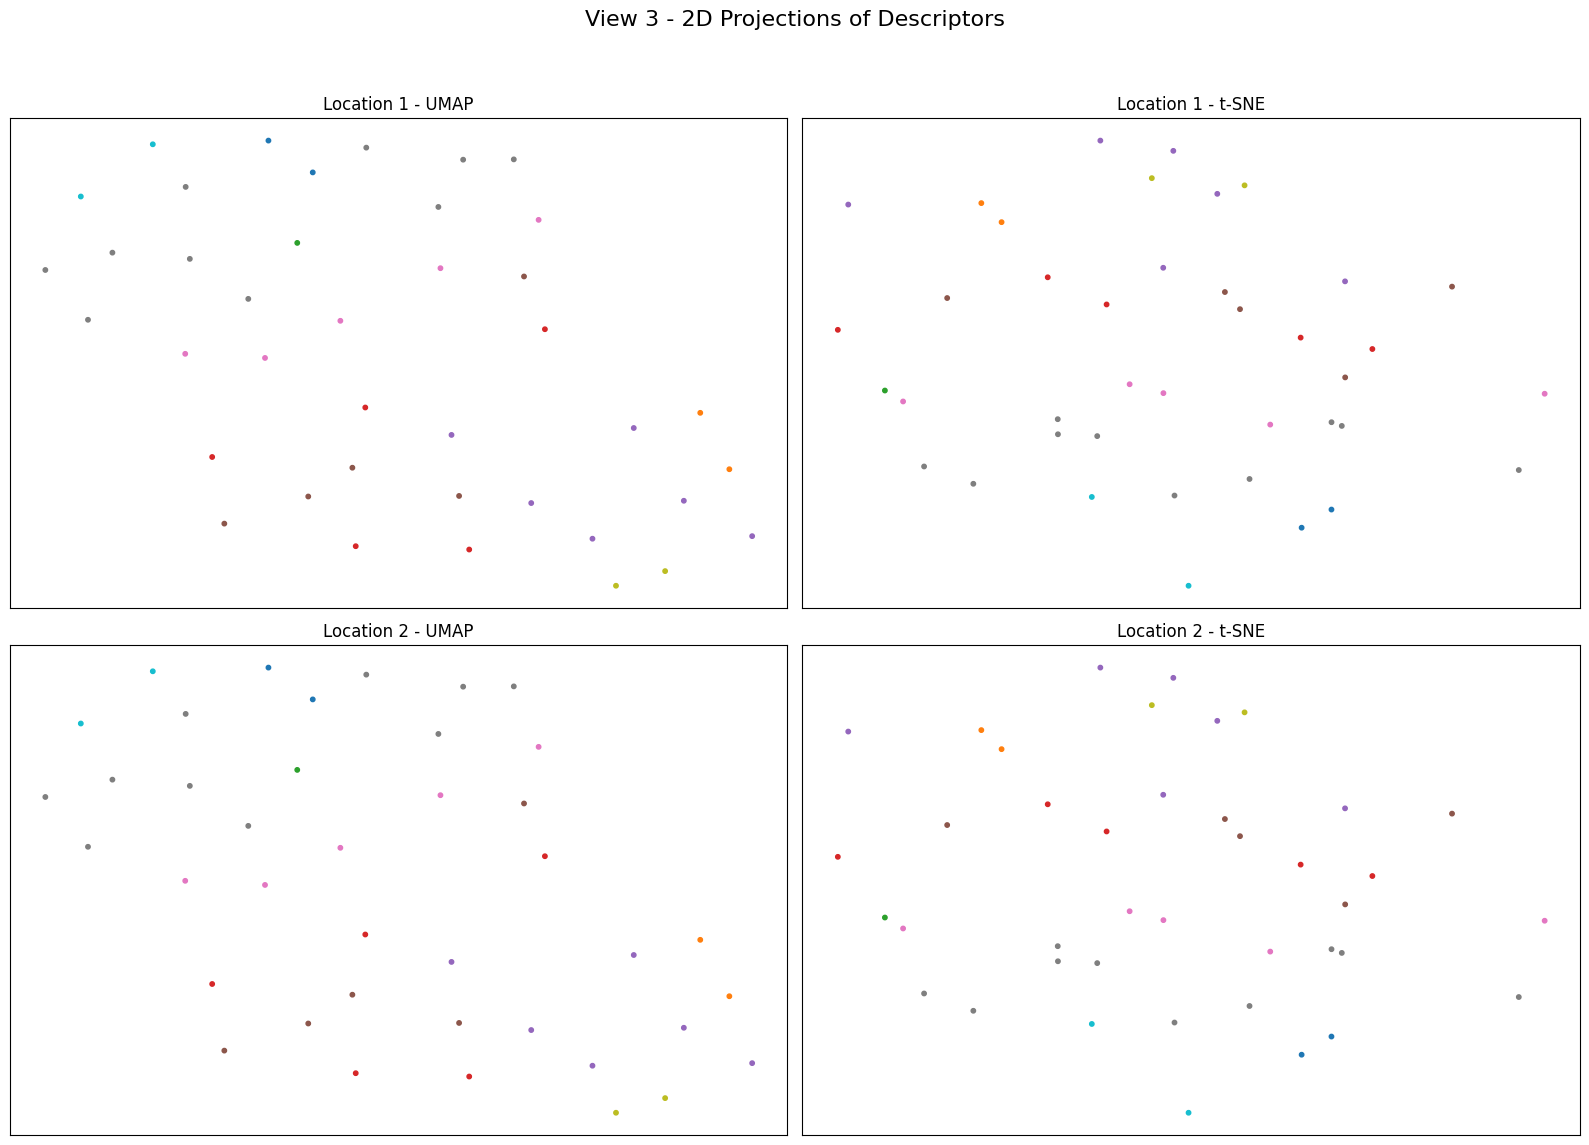

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


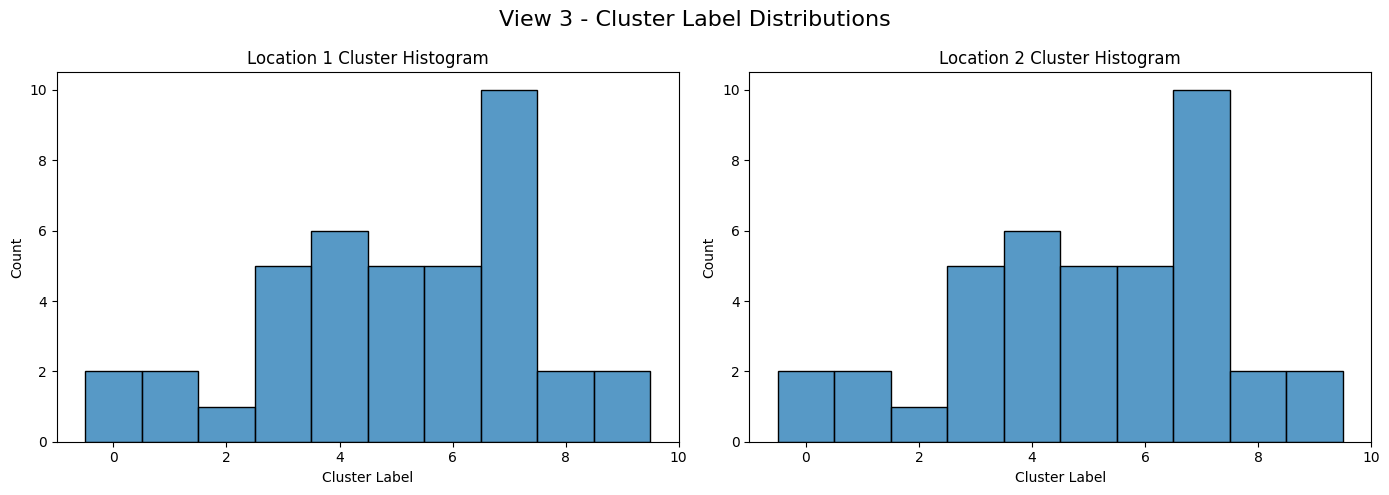

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


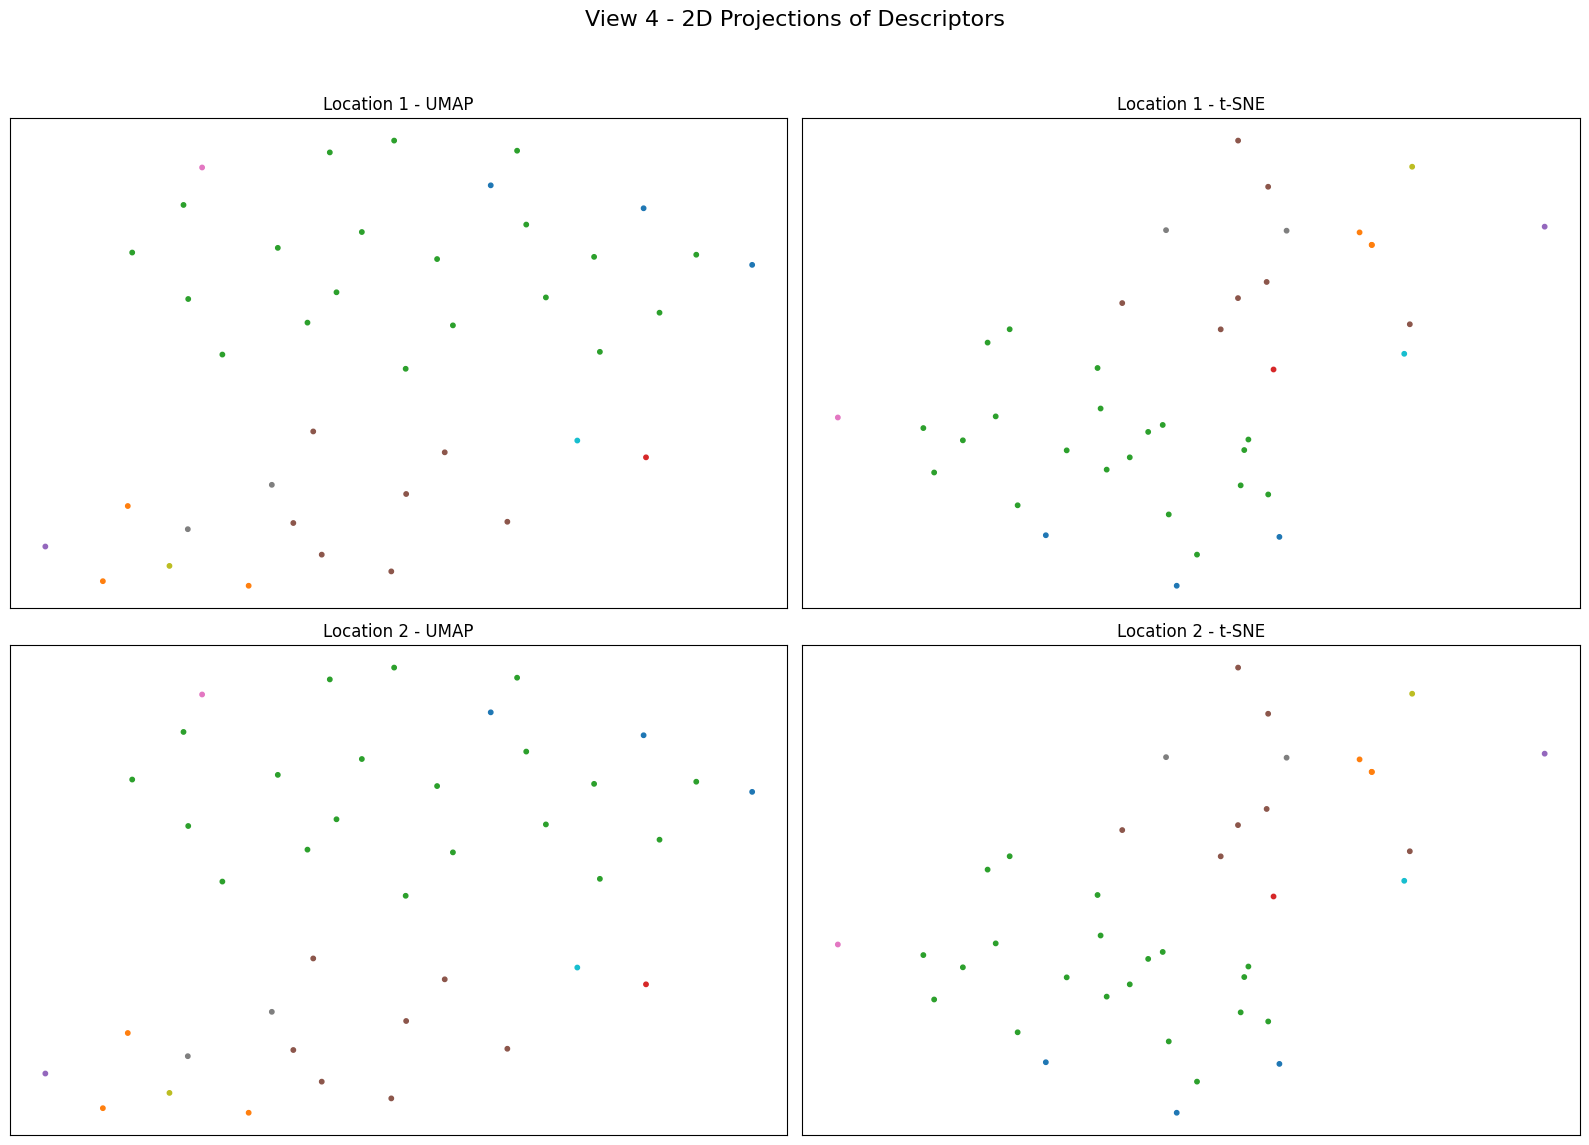

/tmp/ipykernel_125247/2464776561.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc1_labels, bins=len(np.unique(loc1_labels)), discrete=True, ax=ax1, palette='tab10')
/tmp/ipykernel_125247/2464776561.py:81: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(loc2_labels, bins=len(np.unique(loc2_labels)), discrete=True, ax=ax2, palette='tab10')


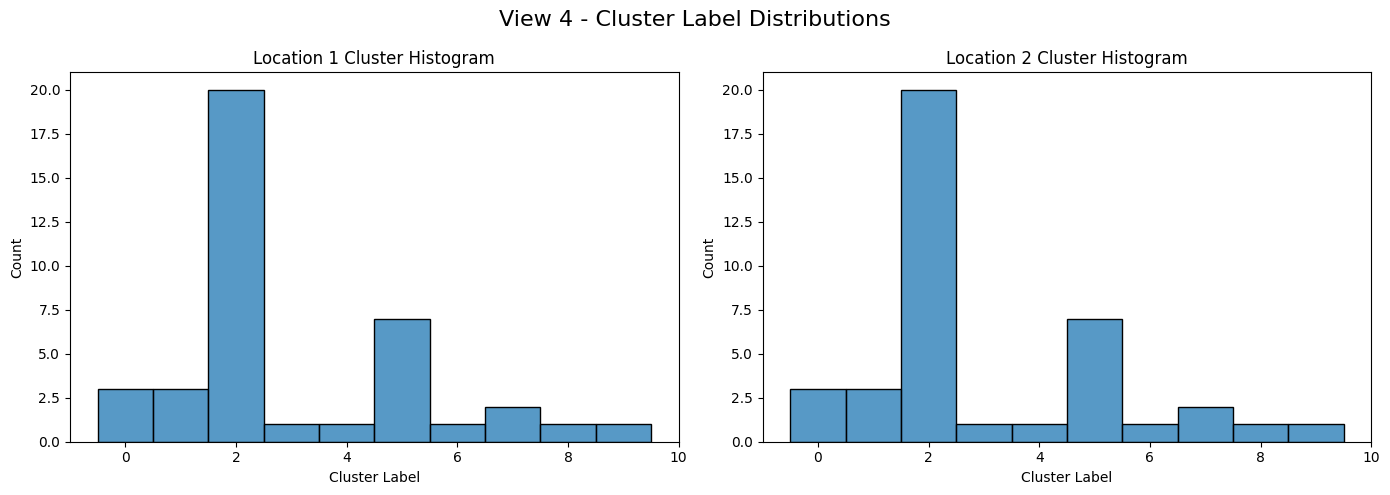

In [21]:
ORB_fast_results_deep = find_images_fast(data_df, "deep", "ORB", plot=True)